In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
from gurobipy import *
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Inner Circle to Remove from all Nodes
customers = 1000
demand_per_customer = 5

#8.90539,48.201454,9.054478,48.292276


F = ox.graph_from_bbox(north = 48.292276, south =48.201454, east = 9.054478, west = 8.90539, network_type = "drive")
Fs = ox.utils_graph.get_largest_component(F, strongly = True)
                       
nodes_c, edges_c = ox.graph_to_gdfs(Fs)
                       
cnodes_df = nodes_c[["y", "x"]].copy()
cnodes_df.columns = ["lat", "lon"]
cnodes_df

#Node_C = cnodes_df.index.values
#Node_C = Node_C.tolist()



sample_nodes_df = cnodes_df.sample(n = customers, random_state= 3)

mylist = [demand_per_customer] * customers

set_of_all_customers = sample_nodes_df.copy()
set_of_all_customers['Demand_C'] = mylist

I = set_of_all_customers.index.values
Node_C1 = set_of_all_customers.index.values
Node_C1 = Node_C1.tolist()
set_of_all_customers.head()

,lat,lon,Demand_C
osmid,,,
303138356,48.253641,8.924421,5
279769968,48.211306,8.961179,5
310111885,48.215808,9.013310,5
248189207,48.214106,9.024095,5
274245988,48.219482,9.026410,5


In [13]:
len(cnodes_df)

1882

In [30]:
# All Nodes
G = ox.graph_from_bbox(north = 48.33122, south =48.203926, east = 9.142871, west = 8.834133, network_type = "drive")
Gs = ox.utils_graph.get_largest_component(G, strongly = True)
nodes, edges = ox.graph_to_gdfs(Gs, nodes=True, edges=True)
                       
nodes_df = nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]
nodes_df

# Create valid Pickup Points outside of Würzburg
set_of_all_pup = pd.concat([nodes_df, cnodes_df, cnodes_df]).drop_duplicates(keep = False)
#set_of_all_pup = pd.concat([set_of_all_pup, unique_df, unique_df]).drop_duplicates(keep=False)

# Remove unwanted Autobahn Nodes
remove_nodes = [259865133, 260115924]

set_of_all_pup = set_of_all_pup.drop(index = remove_nodes)

PuP_S = set_of_all_pup.index.values
PuP_S = PuP_S.tolist()
J = set_of_all_pup.index.values

capacity_per_pup = 5500
cap_list = [capacity_per_pup] * len(set_of_all_pup)
set_of_all_pup["Capacity_pup"] = cap_list

Nodes_S = PuP_S + Node_C1

set_of_all_pup

,lat,lon,Capacity_pup
osmid,,,
27238757,48.255310,8.837629,5500
27238758,48.253274,8.835789,5500
30333819,48.290786,9.065142,5500
30333885,48.312413,9.062118,5500
30333889,48.312744,9.061668,5500
...,...,...,...
9291803298,48.274997,8.861327,5500
9291803300,48.275128,8.861584,5500
9307191364,48.307582,8.927532,5500


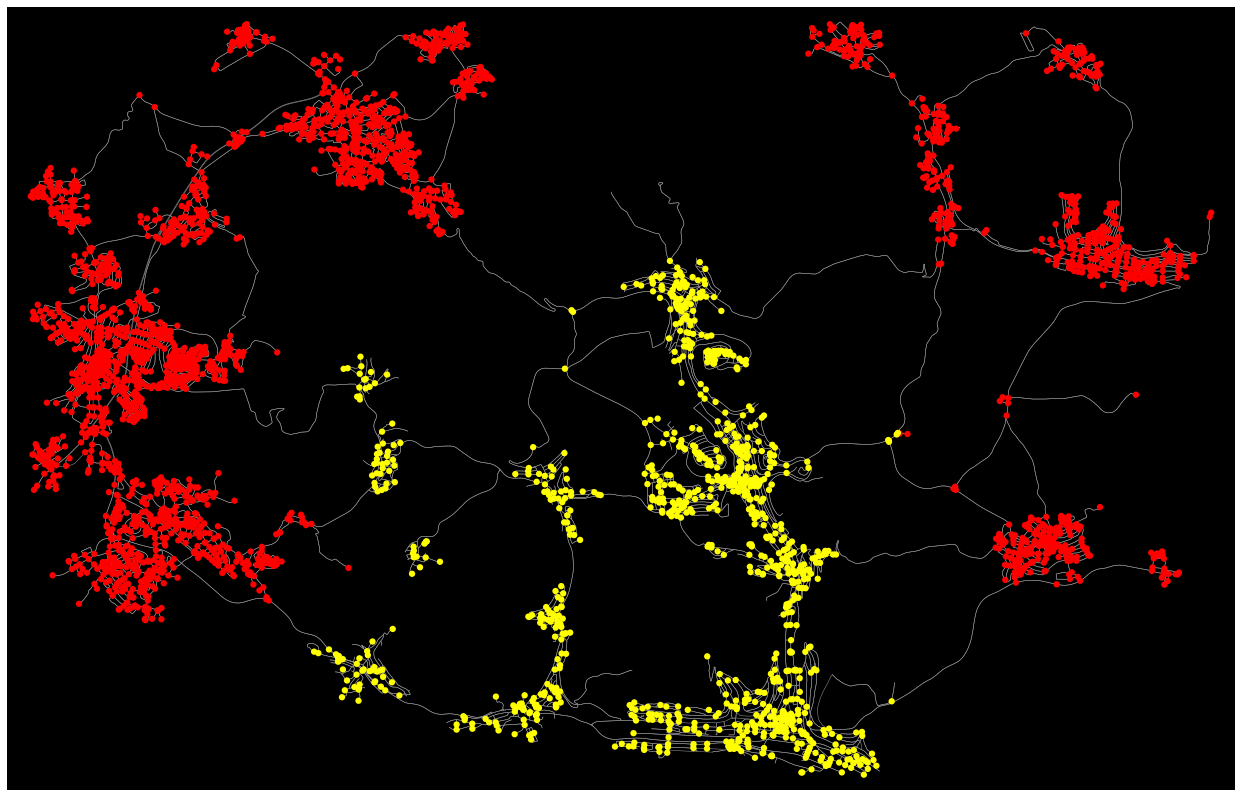

In [31]:
# Sanity Check
ns = []
for node in Gs.nodes():
    if node in PuP_S:
        ns.append(40)
    elif node in Node_C1:
        ns.append(40)
    else:
        ns.append(0)
        
nc = []
for node in Gs.nodes():
    if node in PuP_S: 
        nc.append("red")
    elif node in Node_C1:
        nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(Gs, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [32]:
mat = pd.read_hdf("distance_albstadt_mat.h5", "mat")
mat

,27238757,27238758,30333648,30333819,30333885,30333889,30333974,30333977,30333991,30334014,...,9290999763,9290999764,9291253447,9291253448,9291803298,9291803300,9307191364,9307191365,9315775993,9393338117
osmid,,,,,,,,,,,,,,,,,,,,,
27238757,0.0,266.0,20411.8,24184.3,26732.4,26782.5,28885.9,28870.2,28972.2,29639.8,...,10660.5,10684.2,10098.6,10025.2,3419.3,3395.4,11310.8,11276.2,13519.1,2126.7
27238758,266.0,0.0,20677.8,24450.3,26998.4,27048.5,29151.9,29136.2,29238.2,29905.8,...,10926.5,10950.1,10364.6,10291.1,3685.3,3661.4,11576.8,11542.2,13785.0,2392.6
30333648,19791.7,20057.6,0.0,3772.5,6320.6,6370.7,8474.1,8458.4,8560.4,9228.0,...,16777.3,16801.0,16051.6,15978.1,19359.1,19400.6,14777.0,14742.5,7504.8,18868.6
30333819,23564.2,23830.1,3772.5,0.0,2548.1,2598.2,4701.6,4685.9,4787.9,5455.5,...,16287.8,16311.4,15562.1,15488.6,22368.5,22344.6,14287.5,14252.9,11277.3,22641.1
30333885,26123.3,26389.2,6331.6,2559.1,0.0,50.1,2153.5,2137.8,2239.8,2907.4,...,18846.9,18870.5,18121.2,18047.7,24927.7,24903.7,16846.6,16812.0,13836.4,25200.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9291803300,2926.7,3192.7,19238.9,22399.7,24947.8,24997.9,27101.3,27085.6,27187.7,27855.2,...,7852.2,7875.9,7220.1,7146.6,23.9,0.0,8432.3,8397.7,12346.2,2341.7
9307191364,11113.7,11379.7,14635.5,14287.5,16835.6,16885.7,18989.1,18973.4,19075.4,19743.0,...,2320.3,2344.0,1594.6,1521.1,8401.1,8377.2,0.0,34.6,11658.8,10528.7
9307191365,11079.1,11345.1,14601.0,14252.9,16801.0,16851.1,18954.5,18938.8,19040.8,19708.4,...,2285.8,2309.4,1560.0,1486.6,8366.5,8342.6,34.6,0.0,11624.3,10494.1


In [33]:
dist_matrix = pd.DataFrame(index=Nodes_S)
dist_matrix = dist_matrix.rename_axis("osmid")
dist_matrix = dist_matrix.merge(mat, left_index=True, right_index=True)
dist_matrix = dist_matrix[dist_matrix.columns.intersection(Nodes_S)]
dist_matrix = dist_matrix.sort_values(by = ["osmid"])
dist_matrix 

,27238757,27238758,30333819,30333885,30333889,30333974,30333977,30333991,30334014,30334018,...,9290901580,9290999763,9290999764,9291253447,9291253448,9291803298,9291803300,9307191364,9307191365,9393338117
osmid,,,,,,,,,,,,,,,,,,,,,
27238757,0.0,266.0,24184.3,26732.4,26782.5,28885.9,28870.2,28972.2,29639.8,29640.3,...,10326.5,10660.5,10684.2,10098.6,10025.2,3419.3,3395.4,11310.8,11276.2,2126.7
27238758,266.0,0.0,24450.3,26998.4,27048.5,29151.9,29136.2,29238.2,29905.8,29906.3,...,10592.4,10926.5,10950.1,10364.6,10291.1,3685.3,3661.4,11576.8,11542.2,2392.6
30333819,23564.2,23830.1,0.0,2548.1,2598.2,4701.6,4685.9,4787.9,5455.5,5456.0,...,17049.9,16287.8,16311.4,15562.1,15488.6,22368.5,22344.6,14287.5,14252.9,22641.1
30333885,26123.3,26389.2,2559.1,0.0,50.1,2153.5,2137.8,2239.8,2907.4,2907.9,...,19609.1,18846.9,18870.5,18121.2,18047.7,24927.7,24903.7,16846.6,16812.0,25200.2
30333889,26173.4,26439.4,2609.2,50.1,0.0,2103.4,2087.7,2189.7,2857.3,2857.8,...,19659.2,18897.0,18920.6,18171.3,18097.8,24977.8,24953.9,16896.7,16862.1,25250.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9291803298,2902.8,3168.8,22412.6,24960.6,25010.8,27114.2,27098.5,27200.5,27868.1,27868.5,...,7817.6,7865.1,7888.7,7232.9,7159.5,0.0,41.5,8445.1,8410.5,2317.8
9291803300,2926.7,3192.7,22399.7,24947.8,24997.9,27101.3,27085.6,27187.7,27855.2,27855.7,...,7804.8,7852.2,7875.9,7220.1,7146.6,23.9,0.0,8432.3,8397.7,2341.7
9307191364,11113.7,11379.7,14287.5,16835.6,16885.7,18989.1,18973.4,19075.4,19743.0,19743.4,...,3082.5,2320.3,2344.0,1594.6,1521.1,8401.1,8377.2,0.0,34.6,10528.7


In [34]:
model = Model()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-23


In [35]:
x = model.addVars(J, name = "x", vtype = GRB.BINARY)
y = model.addVars(I, J, name = "y", vtype = GRB.BINARY)
model.update()

In [36]:
model.setObjective(quicksum(dist_matrix.loc[i,j] * y[i,j] for i in I for j in J), GRB.MINIMIZE)

In [37]:
# Amount of PuPs
P = 10

In [38]:
for i in I:
    model.addConstr(quicksum(y[i,j] for j in J) == 1)
    
model.addConstr(quicksum(x[j] for j in J) == P)

model.addConstrs(quicksum(set_of_all_customers.loc[i].Demand_C * y[i,j] for i in I) <= set_of_all_pup.loc[j].Capacity_pup * x[j] for j in J)

model.addConstrs(y[i,j] <= x[j] for j in J for i in I)
model.update()

In [39]:
#model.write("online_flm.lp")
model.Params.MIPGap = 0.07
model.optimize()

Set parameter MIPGap to value 0.07
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2849847 rows, 2848846 columns and 11389692 nonzeros
Model fingerprint: 0xbf492367
Variable types: 0 continuous, 2848846 integer (2848846 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [3e+01, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 1.574706e+07
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 2846 rows and 0 columns (presolve time = 15s) ...
Presolve removed 2846 rows and 0 columns (presolve time = 20s) ...
Presolve removed 2846 rows and 0 columns
Presolve time: 24.11s
Presolved: 2847001 rows, 2848846 columns, 8540846 nonzeros
Variable types: 0 continuous, 2848846 integer (2848846 binary)
Found heuris

In [40]:
# PuP Printer
print("The following Pickup-Points are established:")
for j in J:
    if x[j].X >= 0.1:
        print("-{}; Coordinates: {}, {}".format(set_of_all_pup.loc[j].name,
                                                set_of_all_pup.loc[j].lat,
                                                set_of_all_pup.loc[j].lon))

The following Pickup-Points are established:
-27238757; Coordinates: 48.2553102, 8.8376291
-27238758; Coordinates: 48.2532742, 8.8357888
-30333819; Coordinates: 48.2907856, 9.0651417
-84418680; Coordinates: 48.2369097, 9.0841059
-251662392; Coordinates: 48.2428196, 9.0789568
-266217309; Coordinates: 48.246831, 8.9053683
-288338086; Coordinates: 48.262097, 9.0545677
-305745397; Coordinates: 48.2906589, 9.0645417
-329403704; Coordinates: 48.2338886, 8.8946013
-9146789165; Coordinates: 48.2961436, 8.9386563


In [41]:
# Create a DF which has all the PuP-Customer Connections given by the model


pup_alloc = []
for i in I:
    for j in J:
        if x[j].X >= 0.1:
            if y[i,j].X >= 0.1:
                pup_alloc.append(set_of_all_pup.loc[j].name)
pup_lat = []
for i in I:
    for j in J:
        if x[j].X >= 0.1:
            if y[i,j].X >= 0.1:
                pup_lat.append(set_of_all_pup.loc[j].lat)
                
pup_lon = []
for i in I:
    for j in J:
        if x[j].X >= 0.1:
            if y[i,j].X >= 0.1:
                pup_lon.append(set_of_all_pup.loc[j].lon)                
                
                
customer_alloc = []
for i in I:
    for j in J:
        if y[i,j].X >= 0.1:
            if x[j].X >= 0.1:
                customer_alloc.append(set_of_all_customers.loc[i].name)
customer_lat = []
for i in I:
    for j in J:
        if y[i,j].X >= 0.1:
            if x[j].X >= 0.1:
                customer_lat.append(set_of_all_customers.loc[i].lat)
                
customer_lon = []
for i in I:
    for j in J:
        if y[i,j].X >= 0.1:
            if x[j].X >= 0.1:
                customer_lon.append(set_of_all_customers.loc[i].lon)
                
# Create DF with the lists                
Alloc_DF = pd.DataFrame(list(zip(pup_alloc,pup_lat, pup_lon, customer_alloc, customer_lat, customer_lon)),
               columns =['PuP_ID',"PuP_lat", "PuP_lon", 'C_ID', "C_LAT", "C_LON"])

# Shortest Path Function

def shortest_path(PuP_ID, C_ID):
    length = nx.shortest_path_length(Gs, source=PuP_ID, target=C_ID, weight= "length")                                 
    return length

# Create new Distance column with the haversine function
Alloc_DF["Distance"] = Alloc_DF.apply(lambda x: shortest_path(x["PuP_ID"], x["C_ID"]), axis=1).round(1)

# Shortest Path Time Function

Fs = ox.utils_graph.get_largest_component(G, strongly = True)
Fs = ox.add_edge_speeds(Fs)
Fs = ox.add_edge_travel_times(Fs)

def shortest_path_time(PuP_ID, C_ID):
    time = nx.shortest_path_length(Fs, source=PuP_ID, target=C_ID, weight= "travel_time")                                 
    return time

# Add New Time Column
Alloc_DF["Travel_Time"] = Alloc_DF.apply(lambda x: shortest_path_time(x["PuP_ID"], x["C_ID"]),axis=1)

Alloc_DF = Alloc_DF.sort_values("PuP_ID")
Alloc_DF

,PuP_ID,PuP_lat,PuP_lon,C_ID,C_LAT,C_LON,Distance,Travel_Time
542,84418680,48.236910,9.084106,310105044,48.216765,9.017928,7615.4,578.7
670,84418680,48.236910,9.084106,248189296,48.208356,9.037761,5888.6,432.5
178,84418680,48.236910,9.084106,310103133,48.215255,9.022779,6646.8,463.1
405,84418680,48.236910,9.084106,248189299,48.208545,9.038689,5899.7,434.1
180,84418680,48.236910,9.084106,254317012,48.208085,9.019855,7052.7,476.2
...,...,...,...,...,...,...,...,...
585,9146789165,48.296144,8.938656,255888293,48.284101,8.997806,6021.5,427.4
849,9146789165,48.296144,8.938656,4038521489,48.288679,8.992759,5899.4,434.6
246,9146789165,48.296144,8.938656,286528338,48.285459,8.997096,6195.7,439.0
952,9146789165,48.296144,8.938656,255701238,48.287709,8.991928,5646.5,404.9


In [42]:
Location_DF = Alloc_DF.groupby("PuP_ID")["PuP_lat", "PuP_lon"].max()
PuP_Index = Location_DF.index.values
PuP_Index

array([  84418680,  251662392,  266217309,  288338086,  305745397,
        329403704, 9146789165], dtype=int64)

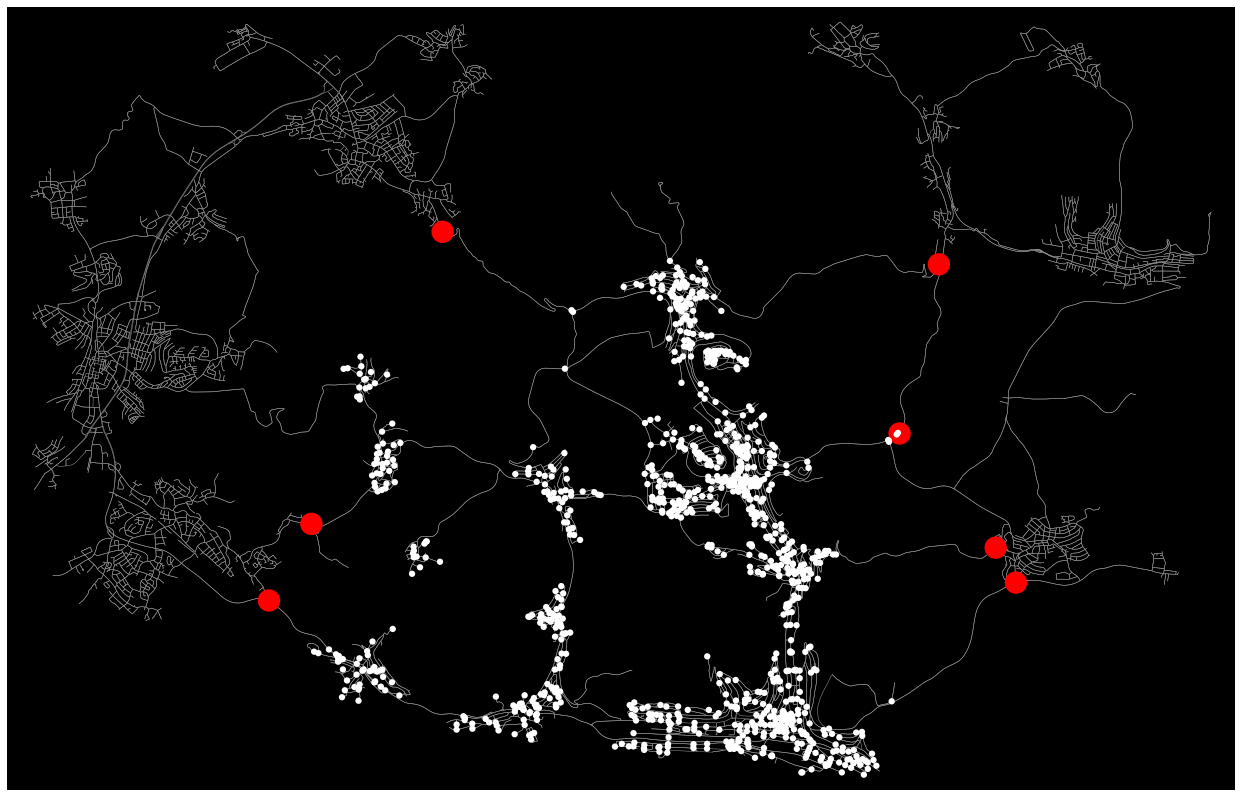

In [43]:
nodes, edges = ox.graph_to_gdfs(Gs, nodes=True, edges=True)


ns = []
for node in Gs.nodes():
    if node in PuP_Index:
        ns.append(500)
    elif node in Node_C1:
        ns.append(40)
    else:
        ns.append(0)

nc = []
for node in Gs.nodes():
    if node in PuP_Index: 
        nc.append("red")
    else:
        nc.append("white")

fig, ax = ox.plot_graph(Gs, node_size = ns, edge_linewidth = 0.5, node_color = nc, 
                        figsize = (22,22), bgcolor = "black")

In [ ]:
#-27238757; Coordinates: 48.2553102, 8.8376291
#-27238758; Coordinates: 48.2532742, 8.8357888
-30333819; Coordinates: 48.2907856, 9.0651417 YES
-84418680; Coordinates: 48.2369097, 9.0841059 YES
#-251662392; Coordinates: 48.2428196, 9.0789568
-266217309; Coordinates: 48.246831, 8.9053683 mayb
#-288338086; Coordinates: 48.262097, 9.0545677
#-305745397; Coordinates: 48.2906589, 9.0645417
#-329403704; Coordinates: 48.2338886, 8.8946013 mb
-9146789165; Coordinates: 48.2961436, 8.9386563 YES

In [66]:
asdasd = [266217309, 30333819, 84418680, 9146789165]



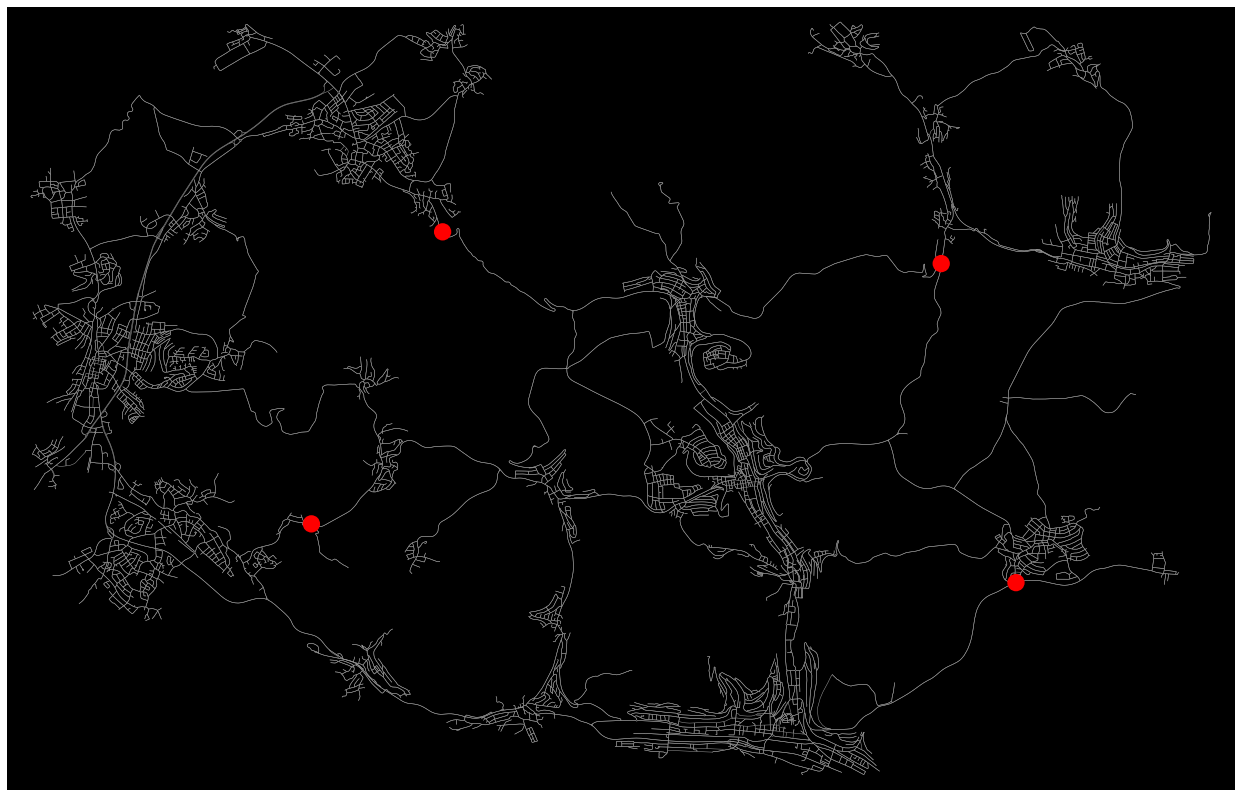

In [67]:
# Sanity Check
ns = []
for node in Gs.nodes():
    if node in asdasd:
        ns.append(300)
    #elif node in Node_C1:
        #ns.append(40)
    else:
        ns.append(0)
        
nc = []
for node in Gs.nodes():
    if node in asdasd: 
        nc.append("red")
    #elif node in Node_C1:
     #   nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(Gs, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [ ]:
#Old Sanity Check Stuff

In [ ]:
48.301298, 8.994981
48.303838, 8.993801
48.302660, 8.981495

In [24]:
input = 48.302660
set_of_all_pup1 = set_of_all_pup.iloc[(set_of_all_pup['lat']-input).abs().argsort()[:50]]
set_of_all_pup1

,lat,lon,Capacity_pup
osmid,,,
1223096117,48.302687,8.837252,5500
669656851,48.302743,8.876019,5500
1301040975,48.302548,8.836211,5500
434003427,48.302792,8.843135,5500
603894442,48.302521,8.931494,5500
283736894,48.302806,8.940736,5500
1223096107,48.302831,8.839720,5500
1223096112,48.302872,8.840403,5500
671487154,48.302883,8.878215,5500


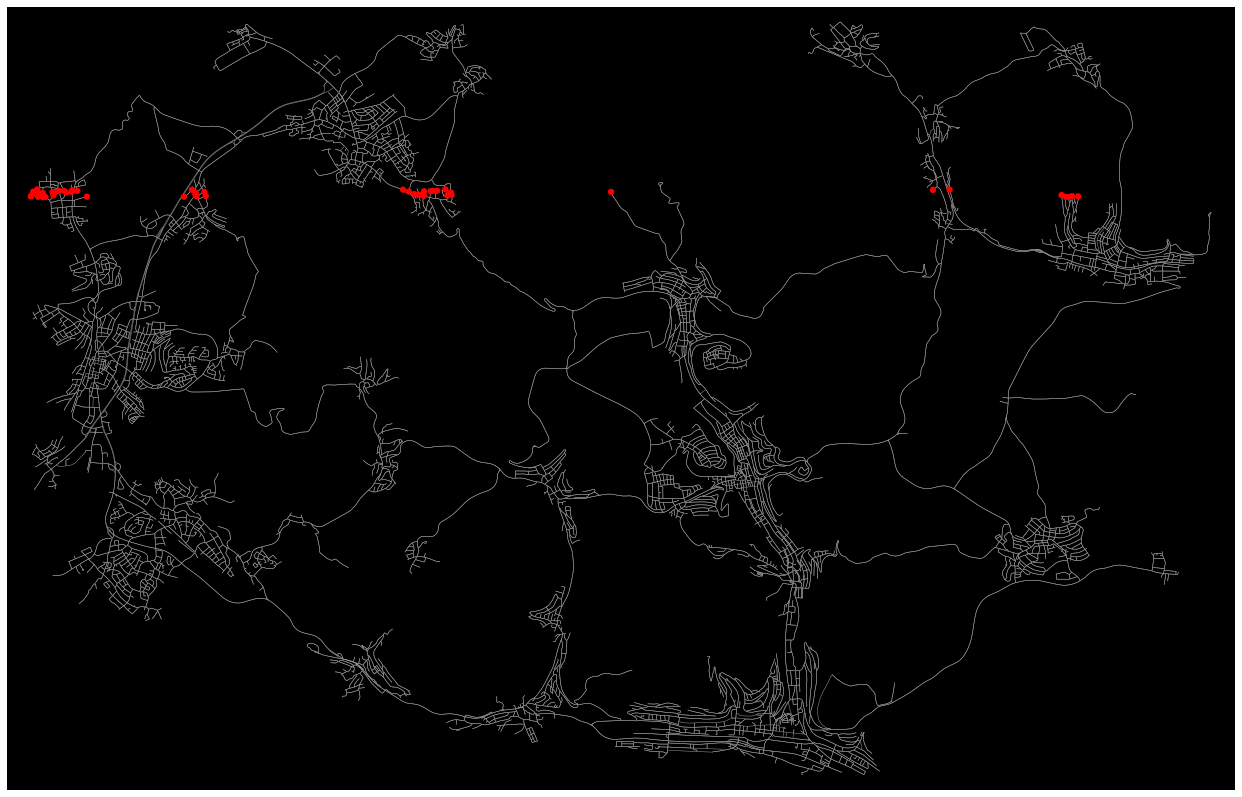

In [25]:
asdasd = set_of_all_pup1.index.values
asdasd = asdasd.tolist()

# Sanity Check
ns = []
for node in Gs.nodes():
    if node in asdasd:
        ns.append(40)
    #elif node in Node_C1:
        #ns.append(40)
    else:
        ns.append(0)
        
nc = []
for node in Gs.nodes():
    if node in asdasd: 
        nc.append("red")
    #elif node in Node_C1:
     #   nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(Gs, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")

In [26]:
input1 = 8.981495
set_of_all_pup123 = set_of_all_pup1.iloc[(set_of_all_pup1['lon']-input1).abs().argsort()[:5]]
set_of_all_pup123

,lat,lon,Capacity_pup
osmid,,,
260115924,48.302896,8.981386,5500
283731210,48.302368,8.940948,5500
283736894,48.302806,8.940736,5500
257577860,48.302288,8.939857,5500
257577861,48.303324,8.939356,5500


In [27]:
lol = [260115924]

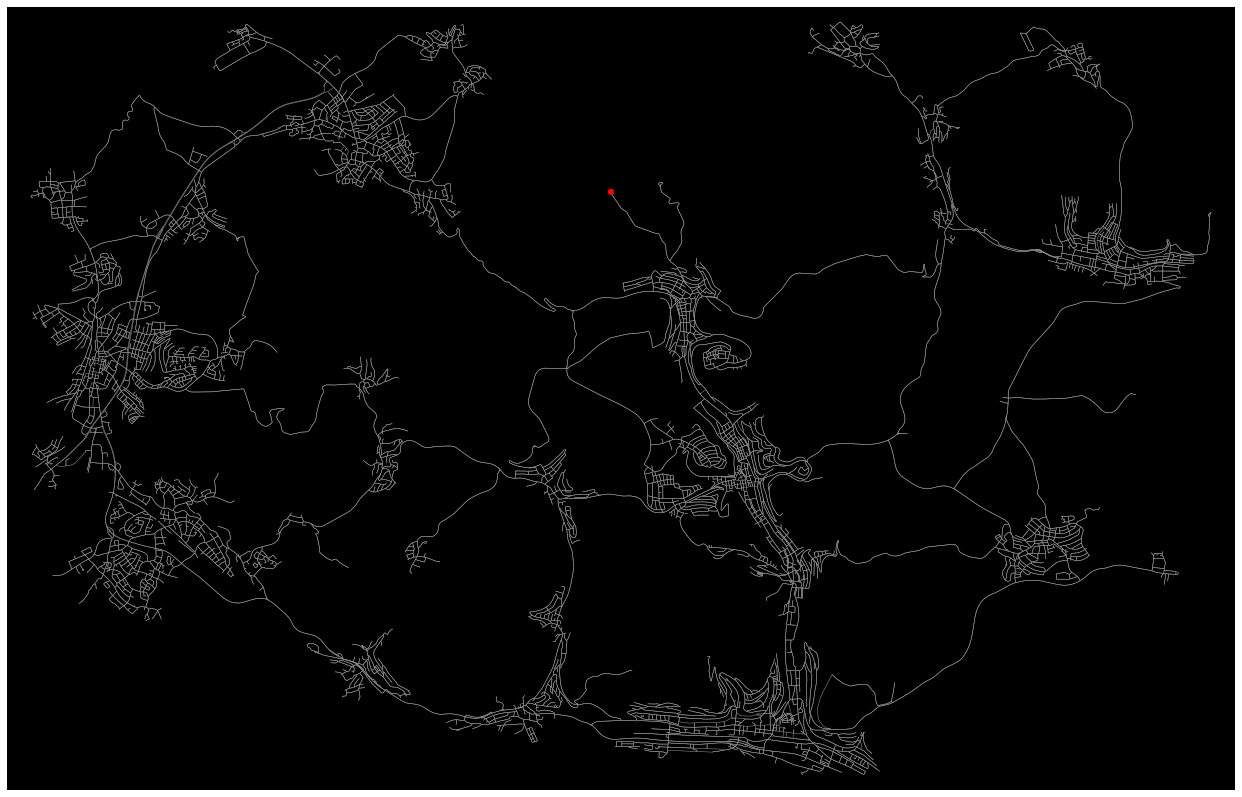

In [28]:
# Sanity Check
ns = []
for node in Gs.nodes():
    if node in lol:
        ns.append(40)
    #elif node in Node_C1:
        #ns.append(40)
    else:
        ns.append(0)
        
nc = []
for node in Gs.nodes():
    if node in lol: 
        nc.append("red")
    #elif node in Node_C1:
     #   nc.append("yellow")
    else:
        nc.append("white")

        

fig, ax = ox.plot_graph(Gs, node_size = ns, edge_linewidth = 0.5, node_color = nc, figsize = (22,22), bgcolor = "black")